In [10]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from itertools import product 
from plot_utils import plot_clusters, scatter_thumbnails, plot_pca_variance
import time

ModuleNotFoundError: No module named 'plot_utils'

### Trainning Process

#### Step 1: Look for faces from video frames

#### Step 2: Calculate the embedding vector for every face

#### Step 3: Perform the clustering of the embedding vectors
     
    The goal of the clustering is to figure out which set of the embedding corresponds to the user.
    We use DBScan for clustering.

    1.We do not know how many people will appear on the images corresponding to one account.
        As a result, we should not use “number_of_clusters” as an input to our clustering algorithm.

    2.In the ideal situation, we expect to get very similar embeddings for the user forming a dense sphere.
        In practice, it is not the case. For example, we can have a clot for a person in glasses and a person without them.
        As a result, centroid based methods will not work for us. We need to use density-based.
        
    For these two reasons, we used DBScan. Major challenge of using DBSCAN algorithm is to find right set hyper parameters(eps and min_samples values) to fit in to the algorithm for getting accurate result.
    
    step 3.1 : Determine Optimal Epsilon And MinPts Values.
        Using Silhouette analysis & Kmeans algorithm to find the ideal no. of clusters for the data
        Approach 1 - “Elbow Method” - Using Euclidean distance method to find optimum epsilon distance(eps)
        Approach 2 - Iterative Approach
        Find the ‘min_samples’ hyper parameter through right cluster formation method
        

In [ ]:
def start_dbscan(self, data, eps = 0.5, min_samples = 5):

    print(eps, min_samples)

    # creating DBSCAN object for clustering the encodings with the metric "euclidean"
    dbscan_model = DBSCAN( eps = eps, min_samples = min_samples, n_jobs = 2, metric = "euclidean")

    # train the model
    dbscan_model.fit(data)

    labels = dbscan_model.labels_

    # determine the total number of unique faces found in the dataset
    # clt.labels_ contains the label ID for all faces in our dataset (i.e., which cluster each face belongs to).
    # To find the unique faces/unique label IDs, used NumPy’s unique function.
    # The result is a list of unique labelIDs
    label_ids = np.unique(dbscan_model.labels_)

    # we count the numUniqueFaces . There could potentially be a value of -1 in labelIDs — this value corresponds
    # to the “outlier” class where a 128-d embedding was too far away from any other clusters to be added to it.
    # “outliers” could either be worth examining or simply discarding based on the application of face clustering.
    num_unique_faces = len(np.where(label_ids > -1)[0])

    print("[INFO] # unique faces: {}".format(num_unique_faces))

    n_noise_ = list(dbscan_model.labels_).count(-1)

    print('Estimated number of noise points: %d' % n_noise_)

    if num_unique_faces > 1:
        sil_score = silhouette_score(data, labels)
        print("Silhouette Coefficient: %0.3f" % sil_score)
        return labels, sil_score

    return labels , None

## Feature Reduction - PCA

In [ ]:
 def get_best_pca_dimensions(self, data, threshold_variance = 95):

    print("\n-------------------- get_best_pca_dimensions --------------------\n")

    n_components =  min(len(data), len(data[0]))

    pca = PCA(n_components=n_components)
    pca.fit(data)
    variance = pca.explained_variance_ratio_ 
    var=np.cumsum(np.round(variance, 3)*100)

    plot_pca_variance(var)

    best_pca_dimensions =  next(item[0] for item in enumerate(var) if item[1] > threshold_variance)
    print("best_pca_dimensions for", threshold_variance ,"% Variance is: ", best_pca_dimensions, "Features\n")
    return best_pca_dimensions

In [ ]:
def create_pca(self, faces, face_encodings, n_components = 20):

    pca = PCA(n_components=n_components)
    pca.fit(face_encodings)

    pca_scale = pca.transform(face_encodings)
    pca_df = pd.DataFrame(pca_scale)

    pca_df_all_data = pd.DataFrame()
    pca_df_all_data['face_location'] = faces.face_location
    pca_df_all_data['image_path'] = faces.image_path
    pca_df_all_data['face_encodings'] = pd.Series(pca_scale.tolist())

    return pca_df_all_data, pca_df

# Determine Optimal Epsilon And MinPts Values

###  Using Silhouette analysis & Kmeans algorithm to find the ideal no. of clusters for the data

In [ ]:
def get_best_num_of_clusters(self, data, start_index, end_index):

    print("\n-------------------- get_best_num_of_clusters --------------------\n")

    end_index =  min(len(data), end_index)
    print(start_index,end_index)
    range_n_clusters = range(start_index,end_index)
    print(range_n_clusters)

    sil = []

    for num_of_clusters in range_n_clusters:

        clusterer = KMeans(n_clusters = num_of_clusters, random_state = 10)
        clusterer_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, clusterer_labels)
        sil.append(silhouette_avg)
        print("For n_clusters =", num_of_clusters, "The average silhouette_score :", silhouette_avg)

    ind = np.argmax(sil) + 2

    print("best_n_clusters: ", ind)

    return ind

### Using Euclidean distance method to find optimum epsilon distance(eps)

In [ ]:
def get_best_eps(self, data, min_samples ,start_index, end_index, step):
    
    print("\n-------------------- get_best_eps --------------------\n")

    pca_eps_values = np.arange(start_index,end_index,step) 

    pca_no_of_clusters = []
    pca_sil_score = []
    pca_epsvalues = []

    for eps in pca_eps_values:

        pca_dbscan_cluster, sil_score = self.start_dbscan(data,eps=eps, min_samples=min_samples)
        pca_epsvalues.append(eps)
        pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster)))
        pca_sil_score.append(sil_score)

    pca_eps_min = list(zip(pca_no_of_clusters, pca_sil_score, pca_epsvalues))
    pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'silhouette_score', 'epsilon_values'])
    print(pca_eps_min_df)
    maxValue = np.nanmax(pca_eps_min_df.silhouette_score.idxmax())
    best_eps = pca_eps_min_df.iloc[maxValue].epsilon_values
    return best_eps

### Find the ‘min_samples’ hyper parameter through right cluster formation method

In [ ]:
def get_best_min_samples_paramerter(self, data, eps ,start_index, end_index):

    print("\n-------------------- get_best_min_samples_paramerter --------------------\n")
    print(start_index, end_index)

    pca_min_pts_range = range(start_index, end_index) 

    pca_no_of_clusters = []
    pca_sil_score = []
    pca_min_pts_values = []

    print(pca_min_pts_range)

    for min_pts in pca_min_pts_range:

        pca_dbscan_cluster, sil_score = self.start_dbscan(data,eps=eps, min_samples=min_pts)
        pca_min_pts_values.append(min_pts)
        pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster)))
        pca_sil_score.append(sil_score)

    pca_min_pts_array = list(zip(pca_no_of_clusters, pca_sil_score, pca_min_pts_values))
    pca_min_pts_df = pd.DataFrame(pca_min_pts_array, columns=['no_of_clusters', 'silhouette_score', 'min_samples_values'])
    print(pca_min_pts_df)

    maxValue = np.nanmax(pca_min_pts_df.silhouette_score.idxmax())
    best_min_samples = pca_min_pts_df.iloc[maxValue].min_samples_values
    return best_min_samples
    

In [ ]:
def cluster_faces(self, faces, face_encodings):

    print("\n-------------------- cluster_faces --------------------\n")

    best_pca_dimensions = get_best_pca_dimensions(face_encodings)

    time.sleep(5)

    pca_df_all_data, pca_df = create_pca(faces, face_encodings, best_pca_dimensions)

    best_n_clusters = get_best_num_of_clusters(pca_df, 2, 128)

    best_eps = get_best_eps(pca_df, best_n_clusters ,0.1, 1.0, 0.1)

    best_min_samples = get_best_min_samples_paramerter(pca_df, best_eps , 1, best_n_clusters * 2)

    print("best_min_samples", best_min_samples, "best_eps", best_eps, "best_n_clusters", best_n_clusters)

    print("\n------------------------- start DBSCAN ------------------------------\n")

    labels, _ = start_dbscan(pca_df, eps = best_eps, min_samples = best_n_clusters)
    pca_df_all_data['cluster'] = labels

    plot_clusters(pca_df, [], labels)

    print("\n------------------------- finish DBSCAN ------------------------------\n")

    return pca_df_all_data, pca_df

In [1]:
from face_detection import FaceDetection
import cv2
import pandas as pd

In [2]:
faceDetection = FaceDetection()

vs = cv2.VideoCapture("../dataset/videos/video.mp4")
faces = []

#Loop Video Stream
while True:

    (grabbed, frame) = vs.read()
    
    temp = faceDetection.detect_faces(frame, "video.mp4")
    faces.extend(temp)
    
#     frame = resizeImage(frame)
    cv2.imshow('camera2',frame) 
    
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break
    
cv2.destroyAllWindows()


-------------------- cluster_faces --------------------


-------------------- get_best_pca_dimensions --------------------



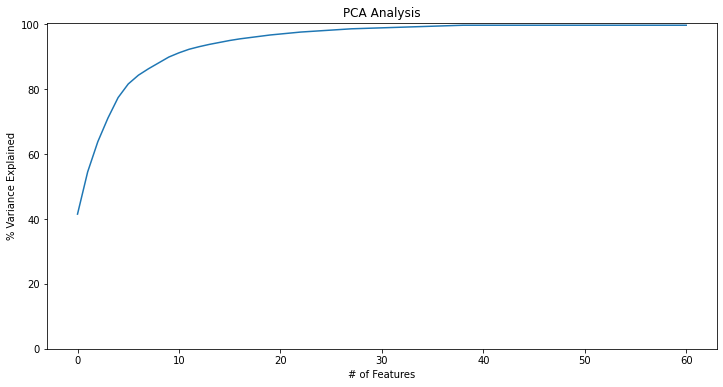

best_pca_dimensions for 95 % Variance is:  16 Features


-------------------- get_best_num_of_clusters --------------------

2 61
range(2, 61)
For n_clusters = 2 The average silhouette_score : 0.5260398734973134
For n_clusters = 3 The average silhouette_score : 0.5373031163530827
For n_clusters = 4 The average silhouette_score : 0.2843807364478679
For n_clusters = 5 The average silhouette_score : 0.31774630015664584
For n_clusters = 6 The average silhouette_score : 0.35960749272107234
For n_clusters = 7 The average silhouette_score : 0.3699780959482948
For n_clusters = 8 The average silhouette_score : 0.38025081067050653
For n_clusters = 9 The average silhouette_score : 0.3861453754554763
For n_clusters = 10 The average silhouette_score : 0.38682151476269283
For n_clusters = 11 The average silhouette_score : 0.3948151460774661
For n_clusters = 12 The average silhouette_score : 0.38199933391735036
For n_clusters = 13 The average silhouette_score : 0.3916379643535059
For n_clusters = 14 

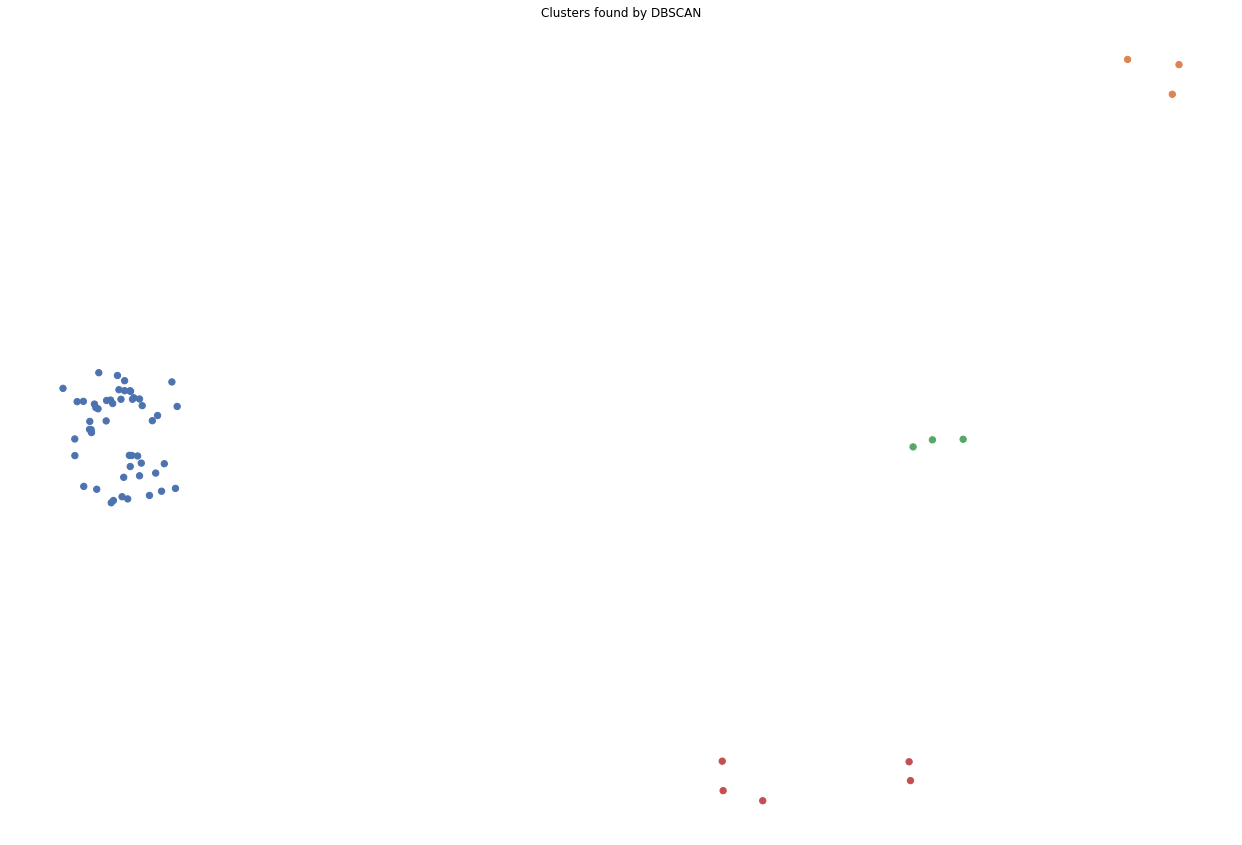


------------------------- finish DBSCAN ------------------------------



In [3]:
faces = pd.DataFrame(faces)
face_encodings = faces['face_encoding'].tolist()
clusterFaces = ClusterFaces()
pca_df_all_data, pca_df = clusterFaces.cluster_faces(faces, face_encodings)